In [1]:
from __future__ import print_function

import sys
import os
import time
import string

import numpy as np
import theano
import theano.tensor as T

import os; import sys; sys.path.append('..')
import gp

import gp.nets as nets
import gp.nets.BatchNormLayer as BatchNormLayer

import lasagne

sys.setrecursionlimit(10000)

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [18]:
%load_ext autoreload
%autoreload 2
from matplotlib.pyplot import imshow

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

# helper function for projection_b
def ceildiv(a, b):
    return -(-a // b)

def build_cnn(input_var=None, n=1, num_filters=8, cudnn='no'):
    import lasagne # For some odd reason it can't read the global import, please PR/Issue if you know why
    projection_type = 'B'
    # Setting up layers
    if cudnn == 'yes':
        import lasagne.layers.dnn
        conv = lasagne.layers.dnn.Conv2DDNNLayer # cuDNN
    else:
        conv = lasagne.layers.Conv2DLayer
    dropout = lasagne.layers.DropoutLayer
    nonlin = lasagne.nonlinearities.rectify
    nonlin_layer = lasagne.layers.NonlinearityLayer
    sumlayer = lasagne.layers.ElemwiseSumLayer
    #batchnorm = BatchNormLayer.BatchNormLayer
    batchnorm = lasagne.layers.BatchNormLayer

    # Setting the projection type for when reducing height/width
    # and increasing dimensions.
    # Default is 'B' as B performs slightly better
    # and A requires newer version of lasagne with ExpressionLayer
    projection_type = 'B'
    if projection_type == 'A':
        expression = lasagne.layers.ExpressionLayer
        pad = lasagne.layers.PadLayer

    if projection_type == 'A':
        # option A for projection as described in paper
        # (should perform slightly worse than B)
        def projection(l_inp):
            n_filters = l_inp.output_shape[1]*2
            l = expression(l_inp, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], ceildiv(s[2], 2), ceildiv(s[3], 2)))
            l = pad(l, [n_filters//4,0,0], batch_ndim=1)
            return l

    if projection_type == 'B':
        # option B for projection as described in paper
        def projection(l_inp):
            # twice normal channels when projecting!
            n_filters = l_inp.output_shape[1]*2 
            l = conv(l_inp, num_filters=n_filters, filter_size=(1, 1),
                     stride=(2, 2), nonlinearity=None, pad='same', b=None)
            l = batchnorm(l)
            return l

    # helper function to handle filters/strides when increasing dims
    def filters_increase_dims(l, increase_dims):
        in_num_filters = l.output_shape[1]
        if increase_dims:
            first_stride = (2, 2)
            out_num_filters = in_num_filters*2
        else:
            first_stride = (1, 1)
            out_num_filters = in_num_filters
 
        return out_num_filters, first_stride

    # block as described and used in cifar in the original paper:
    # http://arxiv.org/abs/1512.03385
    def res_block_v1(l_inp, nonlinearity=nonlin, increase_dim=False):
        # first figure filters/strides
        n_filters, first_stride = filters_increase_dims(l_inp, increase_dim)
        # conv -> BN -> nonlin -> conv -> BN -> sum -> nonlin
        l = conv(l_inp, num_filters=n_filters, filter_size=(3, 3),
                 stride=first_stride, nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)

        l = nonlin_layer(l, nonlinearity=nonlin)
        l = dropout(l, p=.2)
        print('adding dropout')        
        
        l = conv(l, num_filters=n_filters, filter_size=(3, 3),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        if increase_dim:
            # Use projection (A, B) as described in paper
            p = projection(l_inp)
        else:
            # Identity shortcut
            p = l_inp
        l = sumlayer([l, p])
        l = nonlin_layer(l, nonlinearity=nonlin)
        return l

    # block as described in second paper on the subject (by same authors):
    # http://arxiv.org/abs/1603.05027
    def res_block_v2(l_inp, nonlinearity=nonlin, increase_dim=False):
        # first figure filters/strides
        n_filters, first_stride = filters_increase_dims(l_inp, increase_dim)
        # BN -> nonlin -> conv -> BN -> nonlin -> conv -> sum
        l = batchnorm(l_inp)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=n_filters, filter_size=(3, 3),
                 stride=first_stride, nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=n_filters, filter_size=(3, 3),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        if increase_dim:
            # Use projection (A, B) as described in paper
            p = projection(l_inp)
        else:
            # Identity shortcut
            p = l_inp
        l = sumlayer([l, p])
        return l

    def bottleneck_block(l_inp, nonlinearity=nonlin, increase_dim=False):
        # first figure filters/strides
        n_filters, first_stride = filters_increase_dims(l_inp, increase_dim)
        # conv -> BN -> nonlin -> conv -> BN -> nonlin -> conv -> BN -> sum
        # -> nonlin
        # first make the bottleneck, scale the filters ..!
        scale = 4 # as per bottleneck architecture used in paper
        scaled_filters = n_filters/scale
        l = conv(l_inp, num_filters=scaled_filters, filter_size=(1, 1),
                 stride=first_stride, nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=scaled_filters, filter_size=(3, 3),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=n_filters, filter_size=(1, 1),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        if increase_dim:
            # Use projection (A, B) as described in paper
            p = projection(l_inp)
        else:
            # Identity shortcut
            p = l_inp
        l = sumlayer([l, p])
        l = nonlin_layer(l, nonlinearity=nonlin)
        return l

    # Bottleneck architecture with more efficiency (the post with Kaiming He's response)
    # https://www.reddit.com/r/MachineLearning/comments/3ywi6x/deep_residual_learning_the_bottleneck/ 
    def bottleneck_block_fast(l_inp, nonlinearity=nonlin, increase_dim=False):
        # first figure filters/strides
        n_filters, last_stride = filters_increase_dims(l_inp, increase_dim)
        # conv -> BN -> nonlin -> conv -> BN -> nonlin -> conv -> BN -> sum
        # -> nonlin
        # first make the bottleneck, scale the filters ..!
        scale = 4 # as per bottleneck architecture used in paper
        scaled_filters = n_filters/scale
        l = conv(l_inp, num_filters=scaled_filters, filter_size=(1, 1),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=scaled_filters, filter_size=(3, 3),
                 stride=(1, 1), nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        l = batchnorm(l)
        l = nonlin_layer(l, nonlinearity=nonlin)
        l = conv(l, num_filters=n_filters, filter_size=(1, 1),
                 stride=last_stride, nonlinearity=None, pad='same',
                 W=lasagne.init.HeNormal(gain='relu'))
        if increase_dim:
            # Use projection (A, B) as described in paper
            p = projection(l_inp)
        else:
            # Identity shortcut
            p = l_inp
        l = sumlayer([l, p])
        l = nonlin_layer(l, nonlinearity=nonlin)
        return l
       
    res_block = res_block_v1

    # Stacks the residual blocks, makes it easy to model size of architecture with int n   
    def blockstack(l, n, nonlinearity=nonlin):
        print('NNN',n)
        for _ in range(n):
            print ('new')
            l = res_block(l, nonlinearity=nonlin)
        return l

    # Building the network
    l_in = lasagne.layers.InputLayer(shape=(None, 4, 75, 75),
                                        input_var=input_var)
    # First layer! just a plain convLayer
    l1 = conv(l_in, num_filters=num_filters, stride=(1, 1),
              filter_size=(3, 3), nonlinearity=None, pad='same')
    l1 = batchnorm(l1)
    l1 = nonlin_layer(l1, nonlinearity=nonlin)

    # Stacking bottlenecks and increasing dims! (while reducing shape size)
#     l1_bs = blockstack(l1, n=n)
#     l1_id = res_block(l1_bs, increase_dim=True)

#     l2_bs = blockstack(l1_id, n=n)
#     l2_id = res_block(l2_bs, increase_dim=True)

#     l3_bs = blockstack(l2_id, n=n)

    l3_bs = blockstack(l1, n=n)

    l3_do = dropout(l3_bs, p=.5)
    
    # And, finally, the 10-unit output layer:
    network = lasagne.layers.DenseLayer(
            l3_do,
#             l1,
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
            Xb = inputs[excerpt]
            yb = targets[excerpt]
            
            Xb = Xb - .5
            
            k_s = np.array([0,1,2,3],dtype=np.uint8)
            for i in range(len(Xb)):
                k = np.random.choice(k_s)
                for j in range(Xb.shape[1]):
                    Xb[j][0] = np.rot90(Xb[j][0], k)
                    
            yield Xb, yb
            
#         yield inputs[excerpt], targets[excerpt]

In [7]:
PATCH_PATH = ('ipmlb')
X_train, y_train, X_test, y_test = gp.Patch.load_rgba(PATCH_PATH)

Loaded /home/d/patches//ipmlb/ in 0.000614881515503 seconds.


In [8]:
X_val = X_train[-X_train.shape[0]/4:]
y_val = y_train[-X_train.shape[0]/4:]

In [9]:
X_train2 = X_train[:-X_train.shape[0]/4]
y_train2 = y_train[:-X_train.shape[0]/4]

In [4]:
n=2
num_filters=64
num_epochs=200
cudnn='yes'
print(n)

2


In [5]:

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network = build_cnn(input_var, n, num_filters, cudnn)


Building model and compiling functions...
NNN 2
new
adding dropout
new
adding dropout


In [98]:
with np.load('/home/d/resnet2.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

In [73]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

pred_fn = theano.function([input_var, target_var], [test_prediction, test_loss, test_acc])
pred2_fn = theano.function([input_var], [test_prediction])

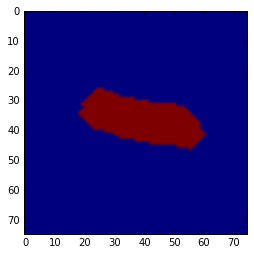

In [30]:
imshow(X_test[0][3])

In [31]:
y_test[0]

0

In [99]:
all_preds = []
for i,p in enumerate(X_test):
    pred = pred2_fn(p.reshape(1,4,75,75))
    all_preds.append(pred[0][:,1][0].astype(np.uint8))
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [ ]:
all_preds

In [91]:
len(all_preds)

15429

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support, f1_score, precision_recall_curve, average_precision_score, zero_one_loss


In [97]:
print(classification_report(y_test, all_preds))

             precision    recall  f1-score   support

          0       0.51      0.99      0.68      8780
          1       0.90      0.06      0.11      8780

avg / total       0.71      0.53      0.39     17560



In [100]:
print(classification_report(y_test, all_preds))

             precision    recall  f1-score   support

          0       0.51      0.99      0.68      8780
          1       0.89      0.05      0.10      8780

avg / total       0.70      0.52      0.39     17560



In [78]:
pred[0][:,1].astype(np.uint8)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [53]:
y_test[0:100]

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1], dtype=uint8)

In [55]:
np.round(pred[:,1])

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32)